In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
import urllib
import json
import os, glob
from IPython.core.display import display, HTML
import logging
import pandas as pd

import warpImage
from pointAnnotator import pointAnnotator, pointCopier, points_from_path
# try:
#     import config as cfg
#     print('loaded device specific config')
# except ImportError as E:
import default_config as cfg
print('loaded default config')



display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib notebook

logging.basicConfig(level=logging.INFO)

loaded default config


In [2]:
localWarp=False

#for some reason, I find you have to run this line twice to actually take effect (depending on matplotlib version)
%matplotlib notebook 

INFO:root:\\allen/programs/braintv/production/visualbehavior/prod0/specimen_1056087714\isi_experiment_1059649483\1059649483_target_map.tif


<IPython.core.display.Javascript object>


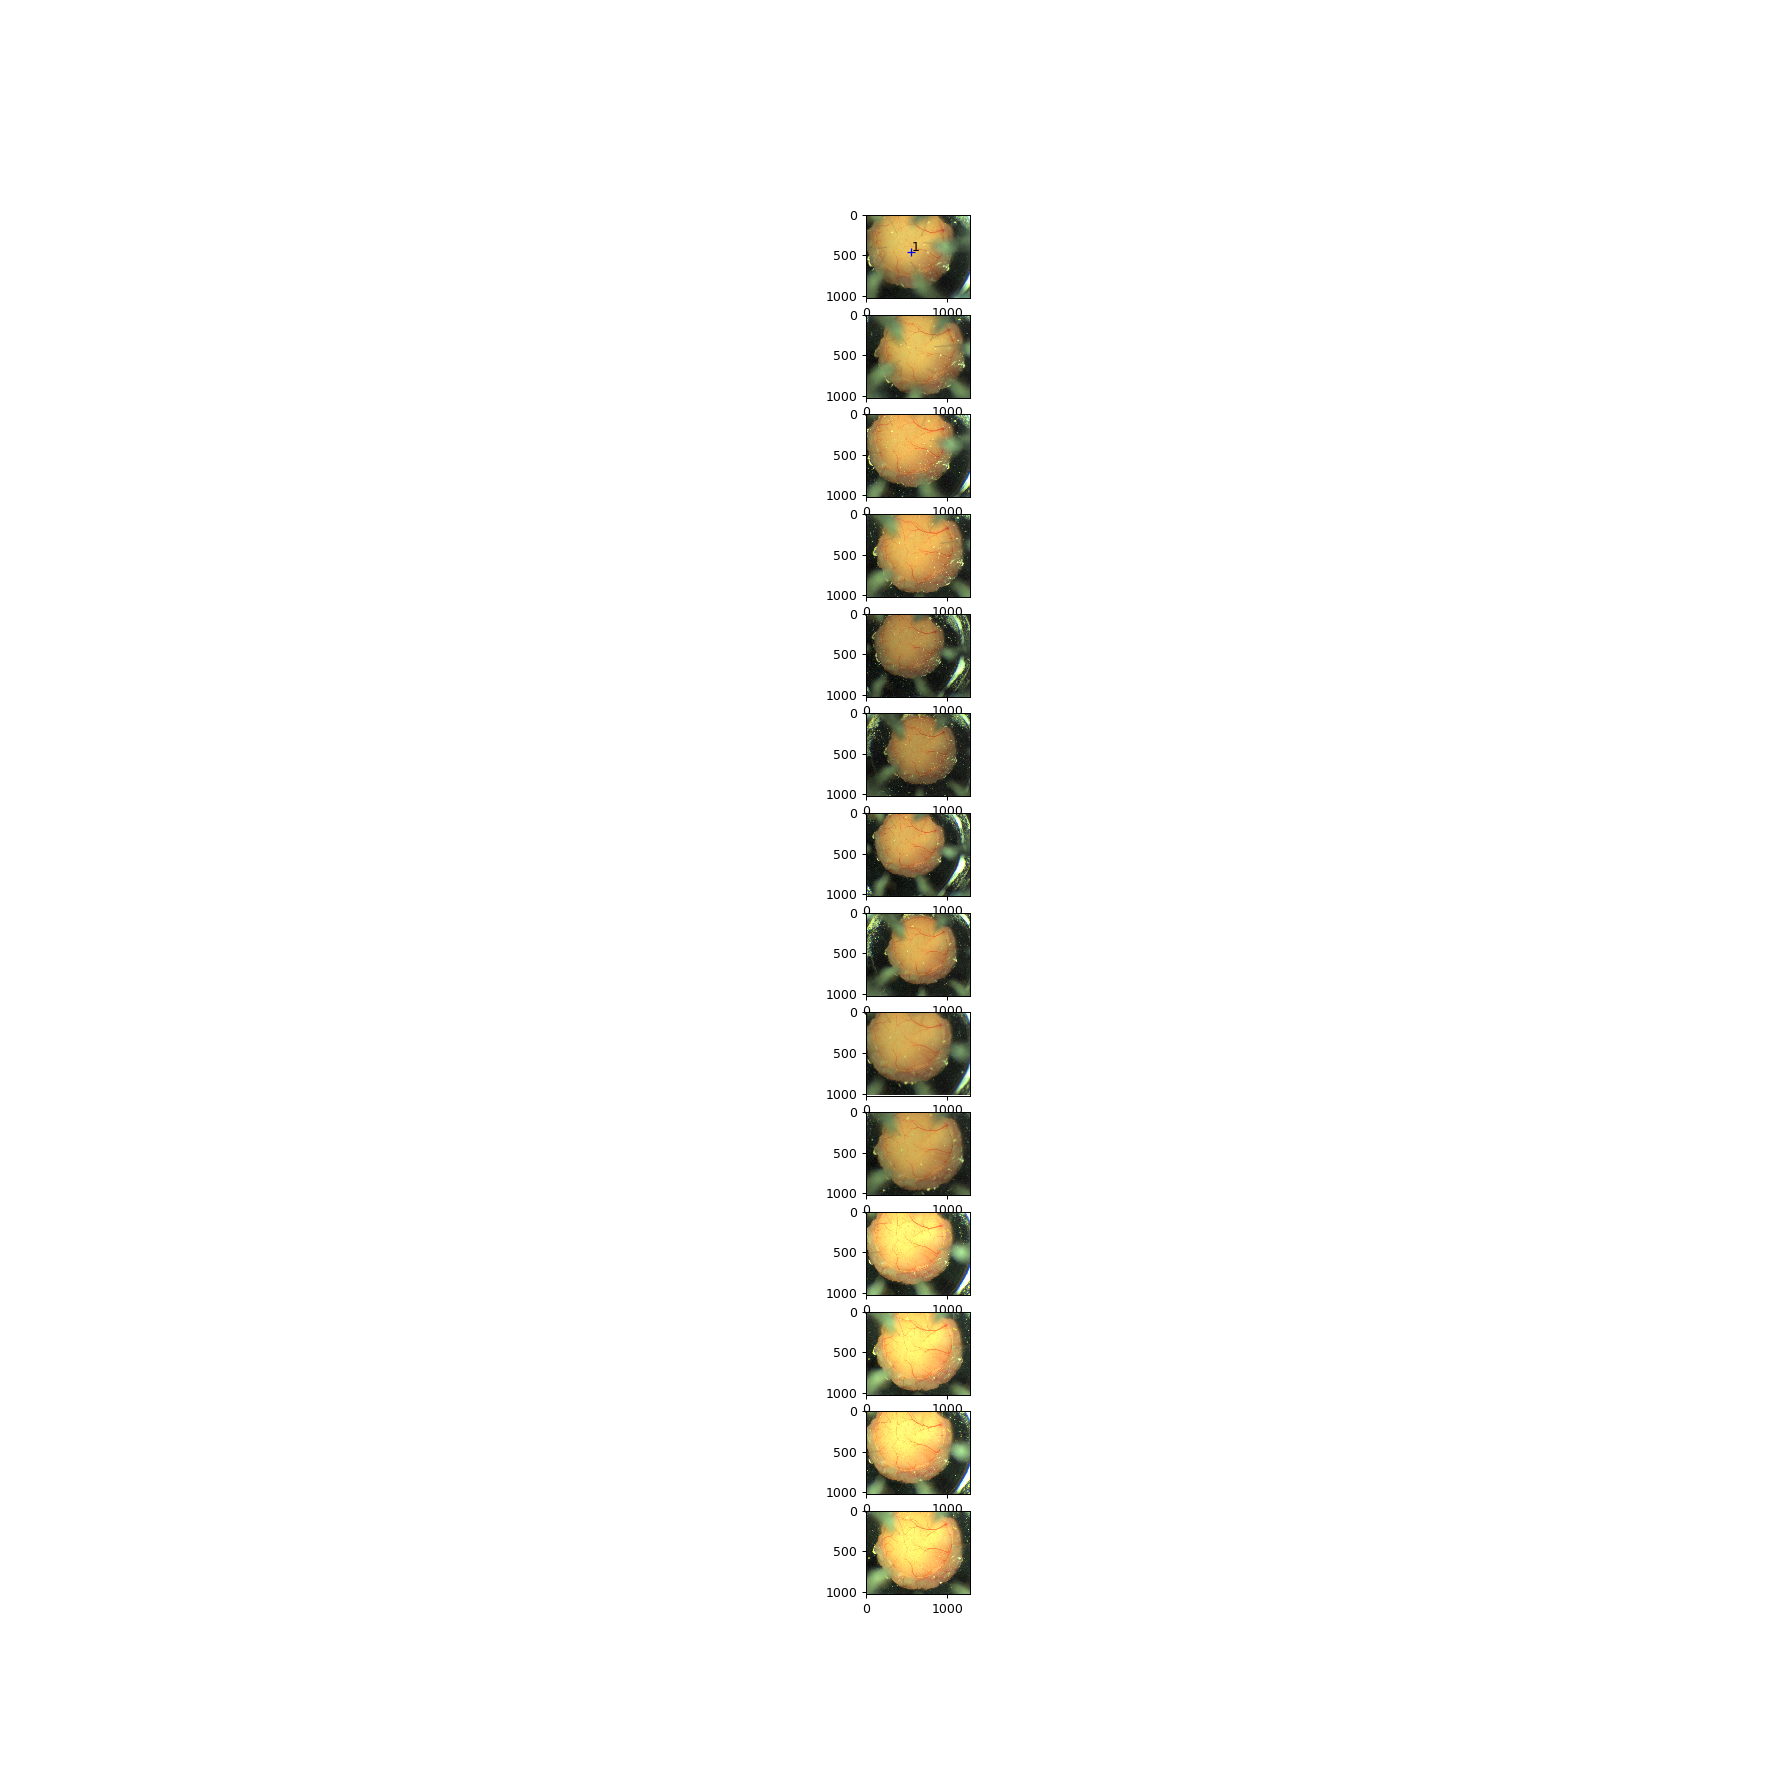

INFO:root:\\w10DTSM18306\neuropixels_data\1078579409_548716_20210125\1078579409_548716_20210125_surface-image2-left.png
INFO:root:\\w10DTSM18306\neuropixels_data\1078579409_548716_20210125\1078579409_548716_20210125_surface-image2-right.png
INFO:root:\\w10DTSM18306\neuropixels_data\1078789264_548716_20210126\1078789264_548716_20210126_surface-image2-left.png
INFO:root:\\w10DTSM18306\neuropixels_data\1078789264_548716_20210126\1078789264_548716_20210126_surface-image2-right.png
INFO:root:\\w10DTSM18306\neuropixels_data\1078983089_548716_20210127\1078983089_548716_20210127_surface-image2-left.png
INFO:root:\\w10DTSM18306\neuropixels_data\1078983089_548716_20210127\1078983089_548716_20210127_surface-image2-right.png
INFO:root:\\w10DTSM18306\neuropixels_data\1079186414_548716_20210128\1079186414_548716_20210128_surface-image2-left.png
INFO:root:\\w10DTSM18306\neuropixels_data\1079186414_548716_20210128\1079186414_548716_20210128_surface-image2-right.png
INFO:root:\\w10DTSM18306\neuropixels

In [16]:
#### get path to network folder with lims images for this mouse
mouse_num = '548716'
desired_image_filenames_contain = ['surface-image2']
json_string = urllib.urlopen("http://lims2/specimens/isi_experiment_details/" + mouse_num + ".json").read()
info = json.loads(json_string)
#print(info)

####################it looks like it always pulls the map with targets on it but what happens if two have targets?

line_type = 'insertion_targets'
experiments = info[0]['isi_experiments']
found = False
for exp in experiments:
    if exp['targets'][line_type]['reticle_space'] is not None:
        if found:
            raise(AssertionError('There are multiple maps with line type {} on them').format(line_type))
        found = True
        passed_isi_id = exp['id']
        newest_vimg_path = r'\\' + info[0]['target_map_image_path'][1:]
        mouse_isi_dir = os.path.split(os.path.split(newest_vimg_path)[0])[0]
        passed_isi_dirname = 'isi_experiment_'+str(passed_isi_id)
        passed_isis_overlay_tifname = str(passed_isi_id)+'_target_map.tif'
        vimg_path = os.path.join(mouse_isi_dir, passed_isi_dirname, passed_isis_overlay_tifname)

logging.info(vimg_path)

#get vasculature image
vimg = cv2.imread(vimg_path)

#get probe insertion image
pimgFileList = []#[r"\\10.128.50.43\sd6\Habituation\958812546_484001_20191001\958812546_484001_20191001_surface-image1-left.png"]#[r"Z:\03132019_416656\2019_03_13_15_11_10_left.png"]
if len(pimgFileList) == 0:
    pimgFileList = cfg.get_insertion_image_paths(mouse_num, desired_image_filenames_contain=desired_image_filenames_contain)
    
canidate_image_count = len(pimgFileList)

pimg_dict = {}
ppa_dict = {}
points_dict = {}


if canidate_image_count > 1:
    fig, ax = plt.subplots(canidate_image_count, figsize=(20,20))#/(2*aspect)))
    for idx, image_path in enumerate(pimgFileList):
        next_ax = ax[idx]
        logging.info(image_path)
        next_image = cv2.imread(image_path)
        next_image = next_image[:, :, [2,1,0]]
        pimg_dict[image_path] = next_ax.imshow(next_image, origin='upper')
        ppa_dict[image_path] = pointAnnotator(pimg_dict[image_path], next_ax)
        directory_path, image_name = os.path.split(image_path)
        image_points = points_from_path(directory_path, image_name, 'landmark_points')
        
        #Comment out the following line if you don't want it to load previous points
        #ppa_dict[image_path].loadPoints(image_points)
        
        points_dict[image_path] = np.array((ppa_dict[image_path].xs, ppa_dict[image_path].ys)).T
        


INFO:root:1


548716
\\w10DTSM18306\neuropixels_data\1078579409_548716_20210125\1078579409_548716_20210125_surface-image2-left.png
[[557.5836  454.39447]]
[]


<IPython.core.display.Javascript object>


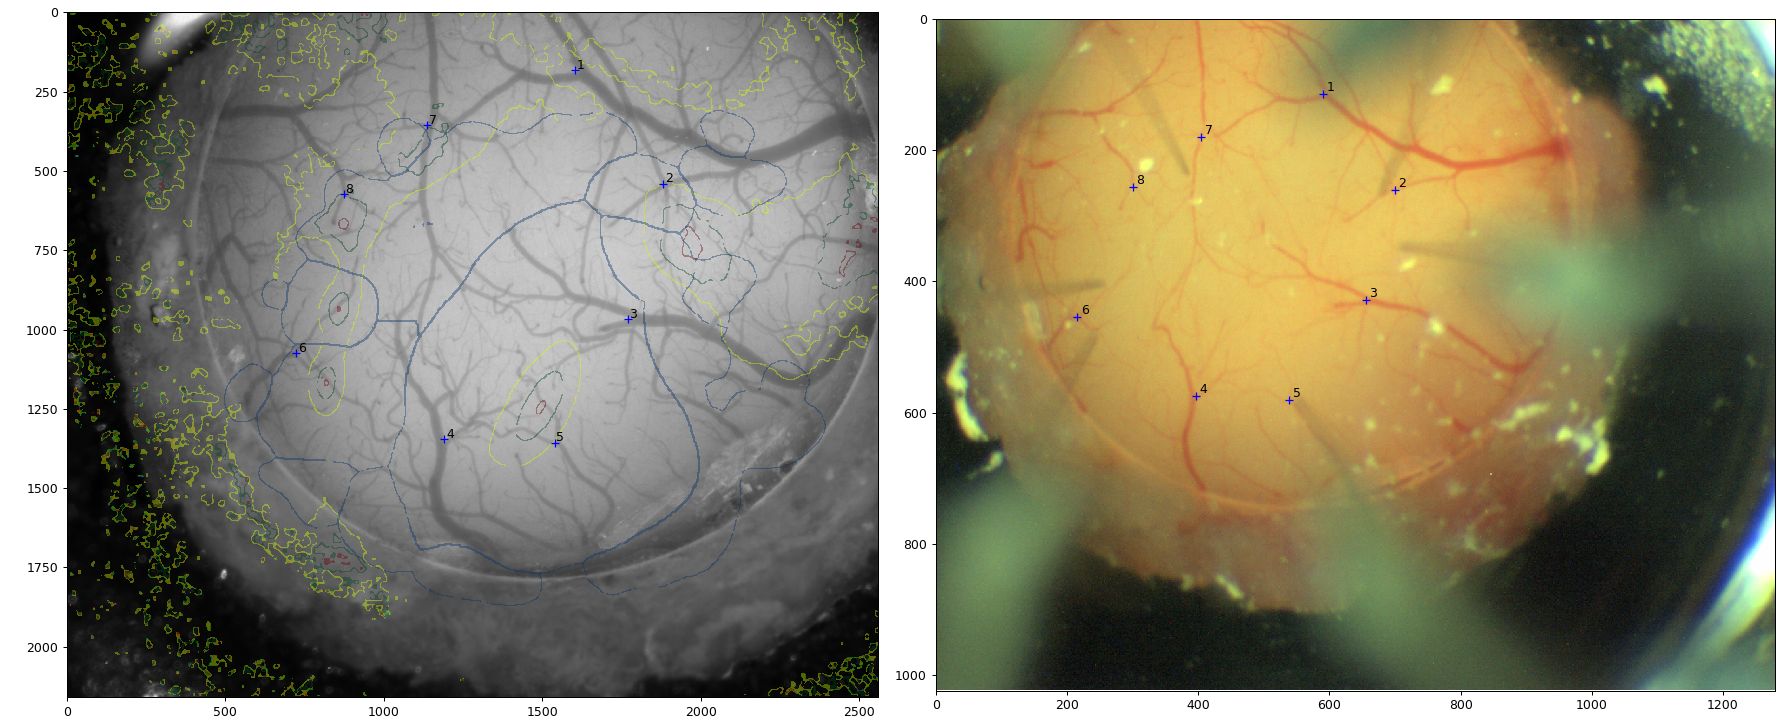

In [17]:
print(mouse_num)
#Display the vasculature images and select points of interest (at least three)
use_day1_insertion_image_as_fiducial = False
if mouse_num in ['532246']:
    use_day1_insertion_image_as_fiducial = True


if canidate_image_count > 1:
    count = 0
    for image_path, annotator in ppa_dict.items():
        if not(np.array_equal(annotator.points, points_dict[image_path])):
            print(image_path)
            print(annotator.points)
            print(points_dict[image_path])
            count+=1
            logging.info(count)
            chosen_image_path = image_path
    try:
        assert(count==1)
    except AssertionError as E:
        logging.error('Image chosen is ambiguous, none or multiple were clicked. Please reset and try again.')
        raise(E)
    pimg_path = chosen_image_path
else:
    pimg_path = pimgFileList[0]

pimg = cv2.imread(pimg_path)
chosen_probe_image_name = os.path.split(pimg_path)[1]
chosen_vasculature_image_name = os.path.split(vimg_path)[1]

#change from opencv bgr default back to rgb
pimg = pimg[:, :, [2,1,0]]
vimg = vimg[:, :, [2,1,0]]
aspect = (pimg.shape[0]+vimg.shape[0])/float(np.max([pimg.shape[1], vimg.shape[1]]))

fiducial_fig, fiducial_ax = plt.subplots(1,2, figsize=(20,20/(2*aspect)))
vax = fiducial_ax[0]
pax = fiducial_ax[1]

if use_day1_insertion_image_as_fiducial:
    fiducial_image_path = cfg.get_warped_image_from_day1(pimg_path)
    print('Reading day 1 warped image in as fiducial at {}'.format(fiducial_image_path))
    camera_for_warp = 'left' if 'left' in os.path.basename(fiducial_image_path) else 'right'
    camera_for_insertion_image = 'left' if 'left' in os.path.basename(pimg_path) else 'right'
    
    assert(camera_for_warp==camera_for_insertion_image)
    fiducial_image = cv2.imread(fiducial_image_path)
    #fiducial_image = PATH_TO_DAY1_WARPED_IMAGE
else:
    fiducial_image = vimg
    
vim = vax.imshow(fiducial_image, origin='upper')
vpa = pointAnnotator(vim, vax)
vasculature_landmark_points = points_from_path(pimg_path, chosen_vasculature_image_name, 'landmark')

#Comment out the following line if you don't want it to load previous points
#vpa.loadPoints(vasculature_landmark_points)

pim = pax.imshow(pimg, origin='upper')
ppa = pointAnnotator(pim, pax)
probe_landmark_points = points_from_path(pimg_path, chosen_probe_image_name, 'landmark')

#Comment out the following line if you don't want it to load previous points
#ppa.loadPoints(probe_landmark_points)

plt.tight_layout(pad=1, w_pad=0, h_pad=0)

<IPython.core.display.Javascript object>


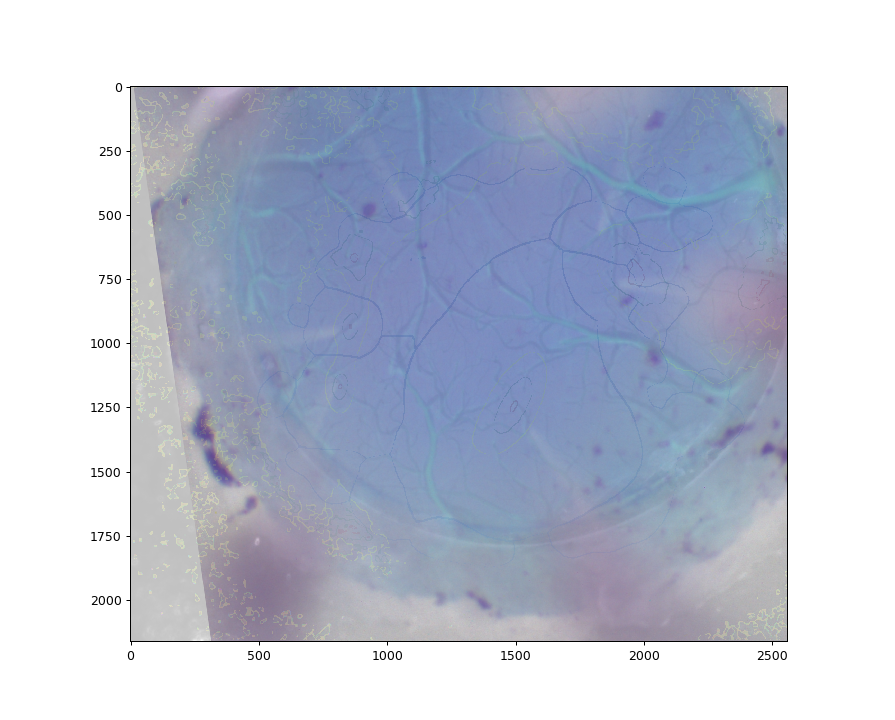

In [18]:
#Compute affine transform to warp probe insertion image to vasculature image coordinates

#reshape points into [numpoints, 2] arrays
ppoints = ppa.points #np.stack((ppa.xs, ppa.ys)).astype(np.float32).T
vpoints = vpa.points #np.stack((vpa.xs, vpa.ys)).astype(np.float32).T

#get perspective transform between images and apply it to probe insertion image
perspective = cv2.findHomography(ppoints, vpoints)
pimg_transform = cv2.warpPerspective(pimg, perspective[0], (vimg.shape[1], vimg.shape[0]))

#transform probe insertion points to use in local warping or plot on transformed image
ppoints_transform = cv2.perspectiveTransform(np.array([ppoints.astype(np.float32)]), perspective[0])
ppoints_transform = np.squeeze(ppoints_transform)

#perform Delaunay triangle local warp if specified
if localWarp:
    pimg_transform = warpImage.warpImage(vimg, pimg_transform, vpoints, ppoints_transform)

#plot overlay of vasculature image and transformed image to compare
overlay_fig, overlay_ax = plt.subplots(figsize=(10,10/aspect))
overlay_ax.imshow(vimg, alpha=0.5)
overlay_ax.imshow(255-pimg_transform, alpha=0.5)


<IPython.core.display.Javascript object>


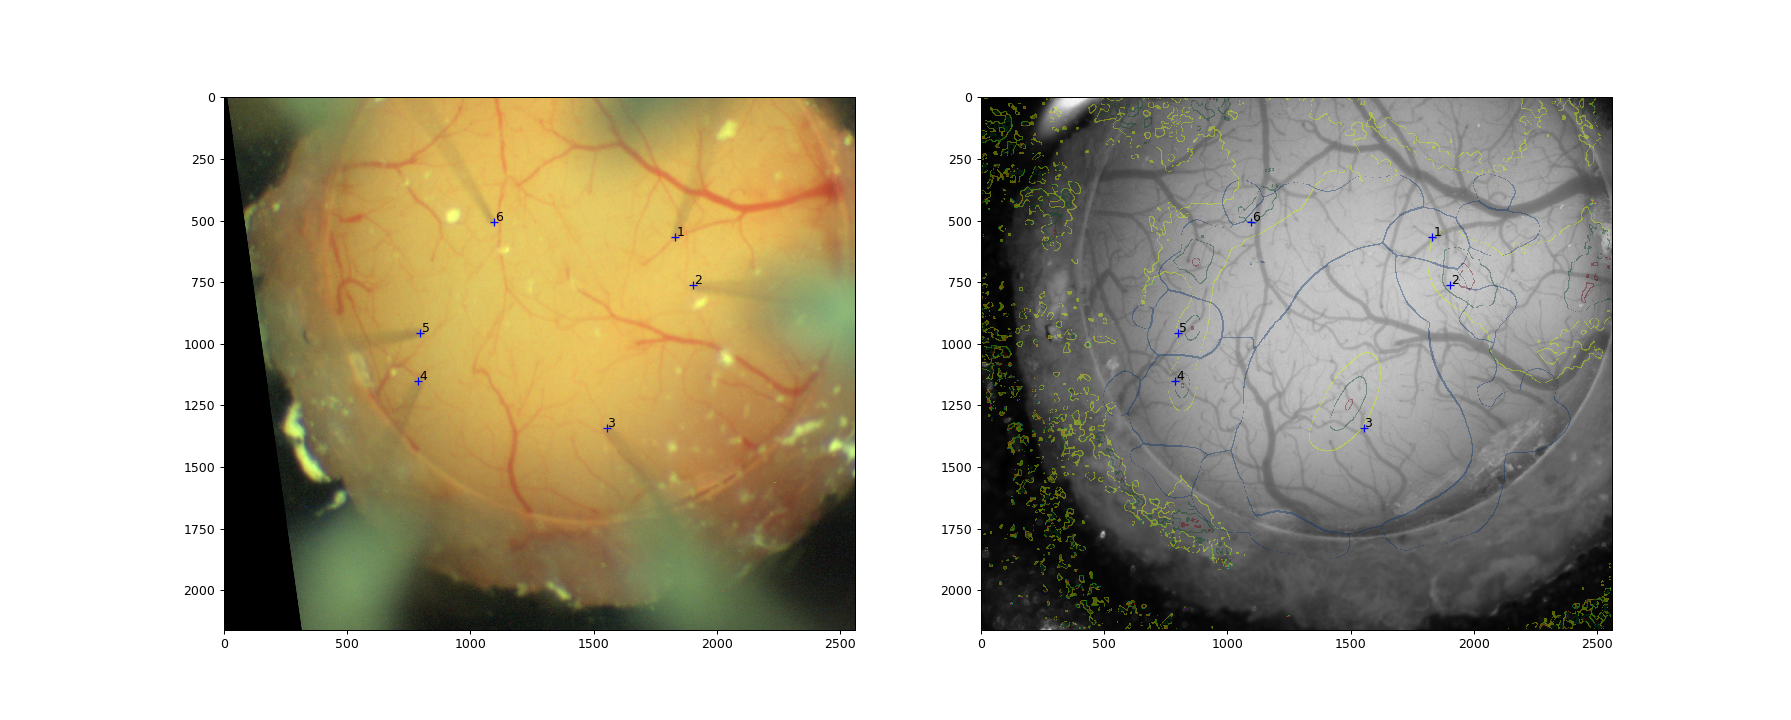

In [19]:
#Select location of probe insertion points in this warped image
insertion_location_fig, insertion_location_ax = plt.subplots(1,2, figsize=(20,20/(2*aspect)))
paffax = insertion_location_ax[0]
vax2 = insertion_location_ax[1]

paff_im = paffax.imshow(pimg_transform, origin='upper')
paffp = pointAnnotator(paff_im, paffax)
probe_insertion_points = points_from_path(pimg_path, chosen_vasculature_image_name, chosen_probe_image_name, 'insertion')
paffp.loadPoints(probe_insertion_points)

#paffpoints = paffp.points  # np.stack((paffp.xs, paffp.ys)).astype(np.float32).T


vim2 = vax2.imshow(vimg, origin='upper')
vpa = pointCopier(vim2, vax2, paffax)
vpa.loadPoints(probe_insertion_points)

In [20]:
print(paffp.points)
print(paffp.points[:, 0])

[[1829.6128   566.66425]
 [1902.2837   759.2423 ]
 [1553.4631  1340.61   ]
 [ 786.78436 1151.6655 ]
 [ 797.685    955.4539 ]
 [1095.636    504.8939 ]]
[1829.6128  1902.2837  1553.4631   786.78436  797.685   1095.636  ]


In [21]:
#####IMPORTANT#####
#please copy and paste the text in red (between triple quotes) over the text below to reset the fields
#then edit accordingly

# your options are: 'visP', 'visAM', 'visPM', 'visLM', 'visAL', 'visRL', 'visRLL', 'visAL', 'visLI', 'visLLA', 'visMMA', 'visMMP', 'visRS', 'visPo', 'nonVis', 'NoInsertion'
#We should come up with a good indicator for border areas - use a forward slash to seperate, with the area that the probe entered on first. e.g. visMMP/visPM if the probe was in MMP close to the border of PM
print(mouse_num) 
#############################################
area_list = ['visAM', 'visPM', 'visP', 'visLM', 'visAL', 'visRL']
confidence_score_list = [ 3, 3, 2, 1, 1, 2 ]#5 is I'm 100% confident that the mark is correct, estimated microns error will be 0
                                    #3 is I'm confident it is wrong but it is close, estimated microns error will be >50
                                    #1 is I'm not confident at all, local vasculature is missing or obscured but estimated microns error will be 0
estimated_error = [0, 0, 0, 0, 0, 0]
estimated_error_x = [0, 0, 0, 0, 0, 0] #if the mark needs to move right this is positive, if it needs to move left this is negative
estimated_error_y = [0, 0, 0, 0, 0, 0] #If the mark needs to go up this is positive, if it needs to go down its negative
    #If we are doing all this work maybe we should just estimate in both X and Y so we can compute where we think the actual location is?
    #Gregg and Corbett talked on 9/16. It seems that the real solution would be to put some werious time into this
    #and write a gui so you could fine tune the points - it would pull up a zoome in for both vasculatore images and the
    #marked point on ISI and you could drag the ISI point around. This would also help ensure that the values get reset...
notes_list = [
    #'ProbeA: 
        'no notes', 
    #'ProbeB: 
        'no notes', 
    #'ProbeC: 
        'under lip of window', 
    #'ProbeD: 
        'bleeding', 
    #'ProbeE: 
        'bleeding', 
    #'ProbeF: 
        'no notes'
]
######################
"""
area_list = ['visAM', 'visPM', 'visP', 'visLM', 'visAL', 'visRL']
confidence_score_list = [ 1, 1, 1, 1, 1, 1 ]#5 is I'm 100% confident that the mark is correct, estimated microns error will be 0
                                    #3 is I'm confident it is wrong but it is close, estimated microns error will be >50
                                    #1 is I'm not confident at all, local vasculature is missing or obscured but estimated microns error will be 0
estimated_error = [0, 0, 0, 0, 0, 0]
estimated_error_x = [0, 0, 0, 0, 0, 0] #if the mark needs to move right this is positive, if it needs to move left this is negative
estimated_error_y = [0, 0, 0, 0, 0, 0] #If the mark needs to go up this is positive, if it needs to go down its negative
    #If we are doing all this work maybe we should just estimate in both X and Y so we can compute where we think the actual location is?
    #Gregg and Corbett talked on 9/16. It seems that the real solution would be to put some werious time into this
    #and write a gui so you could fine tune the points - it would pull up a zoome in for both vasculatore images and the
    #marked point on ISI and you could drag the ISI point around. This would also help ensure that the values get reset...
notes_list = [
    #'ProbeA: 
        'No notes', 
    #'ProbeB: 
        'No notes', 
    #'ProbeC: 
        'No notes', 
    #'ProbeD: 
        'No notes', 
    #'ProbeE: 
        'No notes', 
    #'ProbeF: 
        'No notes'
]
"""
#############################

print(area_list)
print(confidence_score_list)
print(estimated_error)
print(notes_list)

548716
['visAM', 'visPM', 'visP', 'visLM', 'visAL', 'visRL']
[3, 3, 2, 1, 1, 2]
[0, 0, 0, 0, 0, 0]
['no notes', 'no notes', 'under lip of window', 'bleeding', 'bleeding', 'no notes']


In [22]:
# save points and transformation matrix
save_path = cfg.get_save_path(pimg_path)#, mouse_num)
#save_path = os.path.join(r'C:\Users\severined\Allen\Neuropixels_Pipeline\probe_locator', mouse_num)
save_dir = os.path.split(save_path)[0]
if not(os.path.isdir(save_dir, )):
    os.mkdir(save_dir)
try:
    np_load_old = np.load
    # modify the default parameters of np.load
    np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
    # call load_data with allow_pickle implicitly set to true
    current_npz = np.load(save_path)
    # restore np.load for future normal usage
    np.load = np_load_old
    #save_dict = {}
    #for thing in current_npz:
    #    print(thing)#, current_npz[thing]
    #    save_dict[thing]= current_npz[thing]
    save_dict = dict(current_npz, allow_pickle=True)
except (IOError, TypeError) as E:
    save_dict = {}

save_dict['vasculatureImageKeypoints'] = vpoints
save_dict['probeImageKeypoints'] = ppoints
save_dict['vasculatureToProbeInsertionTransform'] = perspective[0]
save_dict['probeInsertionPointsTransformed'] = paffp.points

if not('contributingInsertionImageNames' in save_dict):
    save_dict['contributingInsertionImageNames']=[{}]
contributingInsertionImageNames_dict = save_dict['contributingInsertionImageNames'][0]
    
this_image_pair = (chosen_probe_image_name, chosen_vasculature_image_name)
probe_list = ['A', 'B', 'C', 'D', 'E', 'F']
for probe in probe_list:
    if not(probe in contributingInsertionImageNames_dict):
        contributingInsertionImageNames_dict[probe] = []
    contributingInsertionImageNames_dict[probe].append(this_image_pair)

save_dict['contributingInsertionImageNames'][0] = contributingInsertionImageNames_dict

if not('probesFromImagePair' in save_dict):
    save_dict['probesFromImagePair']=[{}]
probesFromImagePair_dict = save_dict['probesFromImagePair'][0]
probesFromImagePair_dict[this_image_pair] = probe_list
save_dict['probesFromImagePair'][0] = probesFromImagePair_dict


if not('imagePairCoordinates' in save_dict):
    save_dict['imagePairCoordinates']=[{}]
imagePairCoordinates_dict = save_dict['imagePairCoordinates'][0]


imagePairCoordinates_dict[chosen_vasculature_image_name+'_landmark_points'] = vpoints
imagePairCoordinates_dict[chosen_probe_image_name+'_landmark_points'] = ppoints
imagePairCoordinates_dict[chosen_probe_image_name+'_to_'+chosen_vasculature_image_name+'_transform'] = perspective[0]
imagePairCoordinates_dict[chosen_probe_image_name+'_to_'+chosen_vasculature_image_name+'_insertion_points'] = paffp.points

save_dict['imagePairCoordinates'][0] = imagePairCoordinates_dict


session_name = cfg.get_session_name(pimg_path)

np.savez(save_path, **save_dict)

save_images_dict = {
    'insertionLocation':insertion_location_fig,
    'overlay':overlay_fig, 
    'fiducial':fiducial_fig
}
for name, fig in save_images_dict.items():
    image_path = os.path.join(save_dir, session_name+'.'+name+'.png')
    print(image_path)
    fig.savefig(image_path)

### SAVE TRANSFORMED PROBE IMAGE TO USE FOR DAY 2 ALIGNMENT IF NECESSARY
camera_used_for_probe_image = 'left' if 'left' in os.path.basename(pimg_path) else 'right'
warped_save_path = os.path.join(save_dir, session_name+'_'+camera_used_for_probe_image+'.warpedInsertionImage.png')
print(warped_save_path)
cv2.imwrite(warped_save_path, pimg_transform)

column_list = [
    'Probe',
    'Area',
    'Confidence score',
    'Estimate microns error',
    'Notes',
    'Estimate microns error X',
    'Estimate microns error Y',
    'ISI Pixel Coordinate X',
    'ISI Pixel Coordinate Y',
    'Images Used'
]


csv_path = os.path.join(save_dir, session_name+'.areaClassifications.csv')
try:
    current_csv_df = pd.read_csv(csv_path,  index_col=False)
except IOError as E:
    current_csv_df = pd.DataFrame(columns=column_list)

current_csv_df.loc[:, 'Probe'] = probe_list
current_csv_df.loc[:, 'Area'] = area_list
current_csv_df.loc[:, 'Confidence score'] = confidence_score_list
current_csv_df.loc[:, 'Estimate microns error'] = estimated_error
current_csv_df.loc[:, 'Estimate microns error X'] = estimated_error_x
current_csv_df.loc[:, 'Estimate microns error Y'] = estimated_error_y
current_csv_df.loc[:, 'Notes'] = notes_list
current_csv_df.loc[:, 'ISI Pixel Coordinate X'] = paffp.points[:, 0]
current_csv_df.loc[:, 'ISI Pixel Coordinate Y'] = paffp.points[:, 1]
current_csv_df.loc[:, 'Images Used'] = [str(this_image_pair)]*6

current_csv_df.to_csv(csv_path, index=False)



\\w10DTSM18306\neuropixels_data\1078579409_548716_20210125\1078579409_548716_20210125.insertionLocation.png
\\w10DTSM18306\neuropixels_data\1078579409_548716_20210125\1078579409_548716_20210125.fiducial.png
\\w10DTSM18306\neuropixels_data\1078579409_548716_20210125\1078579409_548716_20210125.overlay.png
\\w10DTSM18306\neuropixels_data\1078579409_548716_20210125\1078579409_548716_20210125_left.warpedInsertionImage.png


In [23]:
current_csv_df.head(6)


Probe   Area  Confidence score  Estimate microns error                Notes  \
0     A  visAM                 3                       0             no notes   
1     B  visPM                 3                       0             no notes   
2     C   visP                 2                       0  under lip of window   
3     D  visLM                 1                       0             bleeding   
4     E  visAL                 1                       0             bleeding   
5     F  visRL                 2                       0             no notes   

   Estimate microns error X  Estimate microns error Y  ISI Pixel Coordinate X  \
0                         0                         0             1829.612793   
1                         0                         0             1902.283691   
2                         0                         0             1553.463135   
3                         0                         0              786.784363   
4                         0                         0              797.684998   
5                         0                         0             1095.635986   

   ISI Pixel Coordinate Y                                        Images Used  
0              566.664246  ('1078579409_548716_20210125_surface-image2-le...  
1              759.242310  ('1078579409_548716_20210125_surface-image2-le...  
2             1340.609985  ('1078579409_548716_20210125_surface-image2-le...  
3             1151.665527  ('1078579409_548716_20210125_surface-image2-le...  
4              955.453918  ('1078579409_548716_20210125_surface-image2-le...  
5              504.893890  ('1078579409_548716_20210125_surface-image2-le...

# Manually save the notebook (Press ctrl S)

In [ ]:
# save notebook as html
saveDirectory = os.path.dirname(pimg_path)
os.system('jupyter nbconvert probeInsertionLocator.ipynb --output ' + os.path.join(saveDirectory, 'probeInsertionNotebook.html'))